In [1]:
#!pip install pillow

#### Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### Insight: determine the batch size number to use 

In [3]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132)

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790)

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


#### Create validation set from training set

In [4]:
X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



#### Preview images (Normal)

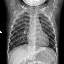

In [5]:
array_to_img(train_images[0])

In [6]:
print(train_labels[0])

[1. 0.]


#### Preview Images (Pneumonia)

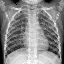

In [7]:
array_to_img(train_images[90])


In [8]:
print(train_labels[90])

[1. 0.]


In [9]:
print('X_train shape: ',np.shape(X_train))
print('y_train shape: ',np.shape(y_train))
print('X_val shape: ',np.shape(X_val))
print('y_val shape: ',np.shape(y_val))

X_train shape:  (632, 64, 64, 3)
y_train shape:  (632, 2)
X_val shape:  (158, 64, 64, 3)
y_val shape:  (158, 2)


#### Reshape  images

In [10]:
#train set
X_train_unrow = X_train.reshape(632, -1)
X_train_unrow.shape

(632, 12288)

In [11]:
#test set
X_val_unrow = X_val.reshape(158, -1)
X_val_unrow.shape

(158, 12288)

#### Labels for images

In [12]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Transpose and resize train and test sets

In [14]:
#training set
y_train_labels_final = np.reshape(y_train[:,0], (632,1))

In [15]:
np.shape(y_train_labels_final)

(632, 1)

In [16]:
#test set
y_val_labels_final = np.reshape(y_val[:,0], (158,1))

In [17]:
np.shape(y_val_labels_final) 

(158, 1)

In [18]:
#scaling the data
X_train_img_final = X_train_unrow/255
X_val_img_final = X_val_unrow/255

type(X_val_img_final)

numpy.ndarray

In [19]:
print(X_train_img_final.shape)
print(X_val_img_final.shape)

(632, 12288)
(158, 12288)


### Baseline model creation

In [20]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='tanh', input_shape=(12288,)))
model.add(layers.Dense(42, activation='tanh'))
model.add(layers.Dense(21, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [21]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_train_img_final,
                    y_train_labels_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val_labels_final))

Epoch 1/50
20/20 [==============================] - 0s 22ms/step - loss: 0.5698 - accuracy: 0.7041 - val_loss: 0.5126 - val_accuracy: 0.7468
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5363 - accuracy: 0.7310 - val_loss: 0.4621 - val_accuracy: 0.7468
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5090 - accuracy: 0.7405 - val_loss: 0.4501 - val_accuracy: 0.7595
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4764 - accuracy: 0.7832 - val_loss: 0.4388 - val_accuracy: 0.7595
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4381 - accuracy: 0.7959 - val_loss: 0.3734 - val_accuracy: 0.8165
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4039 - accuracy: 0.8449 - val_loss: 0.4306 - val_accuracy: 0.7722
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4158 - accuracy: 0.8228 - val_loss: 0.3492 - val_accuracy: 0.8481
Epoch 8/50
20/20 [=

In [22]:
results_train = model.evaluate(X_train_img_final, y_train_labels_final)

20/20 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.9383


In [23]:
results_val = model.evaluate(X_val_img_final, y_val_labels_final)

5/5 [==============================] - 0s 2ms/step - loss: 0.2268 - accuracy: 0.9051


#### Training accuracy = 0.9797. Test acc = 0.8030. Subsequent models must improve these thresholds.

In [24]:
#plot acc vs loss for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();

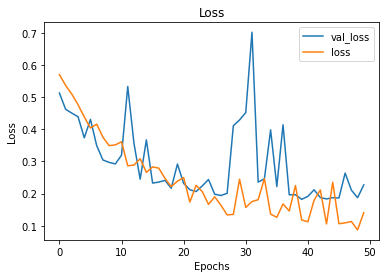

In [25]:
visualize_results(results)

#### Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve. Any subsequent models must reduce the variance and overfitting of the baseline model.


In [26]:
# For Tuesday: Resolve overfitting(EarlyStopping), Attempt L1, L2 or dropout regularization, determine if normalization is 
# necessary, create convolution filter. After that, look at weight initializers (Lecun and He), optmizers(RMSProp, Adam)

#### Will adding EarlyStopping improve the model?

In [27]:
np.random.seed(42)
model2 = models.Sequential()
model2.add(layers.Dense(63, activation='tanh', input_shape=(12288,)))
model2.add(layers.Dense(42, activation='tanh'))
model2.add(layers.Dense(21, activation='tanh'))
model2.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [28]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5',
                                                                                 monitor='val_loss', save_best_only=True)]

In [29]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results2 = model2.fit(X_train_img_final,
                    y_train_labels_final,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val_labels_final))

Epoch 1/50
20/20 [==============================] - 0s 13ms/step - loss: 0.6111 - accuracy: 0.7263 - val_loss: 0.5330 - val_accuracy: 0.7468
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5277 - accuracy: 0.7294 - val_loss: 0.6466 - val_accuracy: 0.7468
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5257 - accuracy: 0.7405 - val_loss: 0.5915 - val_accuracy: 0.7278
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4682 - accuracy: 0.7959 - val_loss: 0.5261 - val_accuracy: 0.7468
Epoch 5/50
20/20 [==============================] - 0s 10ms/step - loss: 0.4741 - accuracy: 0.7769 - val_loss: 0.3733 - val_accuracy: 0.8671
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.4003 - accuracy: 0.8354 - val_loss: 0.4700 - val_accuracy: 0.7658
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.3775 - accuracy: 0.8465 - val_loss: 0.6128 - val_accuracy: 0.7532
Epoch 8/50
20/20 [

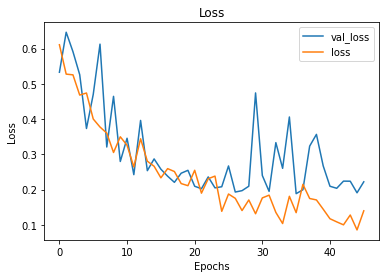

In [30]:
visualize_results(results2)

#### Variation in val_loss is still very high. Additionally, overfitting issue still hasn't been resolved. Will build a CNN, then attempt to control overfitting.

In [31]:
#CNN model
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(64 ,64,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='tanh'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='tanh'))
model3.add(layers.Dense(42, activation='tanh'))
model3.add(layers.Dense(21, activation='tanh'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results3 = model3.fit(X_train_img_final,
                    y_train_labels_final,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val_labels_final))

Epoch 1/50


ValueError: in user code:

    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 12288]


In [ ]:
visualize_results(results3)

#### The variation has been reduced and the curves are beginning to converge, but there is still overfitting. From here, we will attempt L1 and L2 regularization